# Data Creation / Curation

This notebook assembles the source data (found in the `src_dir`) into a set of parquet and geoparquet files that will be easier to work with. 

This first block of code imports the coding libraries that we need (`pandas` and `geopandas`), as well as `Path` from the `pathlib` library, and `os` (operating system) and `re` (regular expressions).

In [1]:
import os, re
import pandas as pd
import geopandas as gpd
from pathlib import Path

src_dir = Path.home() / 'data'
out_dir = Path.home() / Path('work/data/clean')
if not out_dir.exists():
    out_dir.mkdir(parents=True)
    print(f"Creating 'clean' directory for output data in {out_dir}.")

## Jaipur Boundary

Read in the Jaipur shape file (actually 3–5 files) and converting it to a single geoparquet file. This is going to make it easier to work with the data *and* save us disk space. In *total* we reduce the size of the files by something like 80%.

In [ ]:
jp = gpd.read_file(src_dir / 'Jaipur_Boundary/18JMC.shp')
jp.plot()
jp.to_parquet(out_dir / 'Jaipur_Boundary.geoparquet')

## Jaipur Wards

The Jaipur wards are split across *multiple* shapefiles, which makes them hard to work with. Here we read in all of the shapefiles in a directory and concatentate (`concat`) them together into a single 'wards geo-data frame'. This is the sort of thing that is easy to do in code but hard to do in ArcGIS, or even QGIS.

<Axes: >

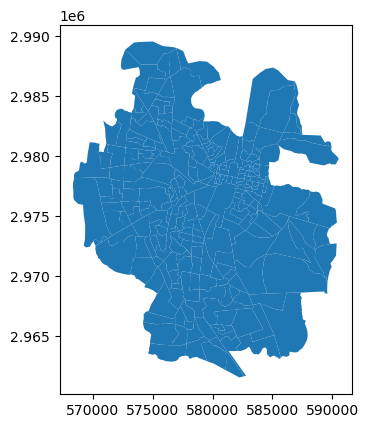

In [2]:
path  = os.path.join(src_dir / 'Jaipur_Wards')
wards = [os.path.join(path,x) for x in os.listdir(path) if x.endswith('.shp')]

wgdf  = gpd.GeoDataFrame(pd.concat([gpd.read_file(w) for w in wards], ignore_index=True), crs=gpd.read_file(wards[0]).crs)
wgdf.to_parquet(out_dir / 'Jaipur_Wards_2.geoparquet')
wgdf.plot()

In [3]:
wgdf.head()

,Id,AREA,Ward_No,POP,DENS_PPH,NAME,geometry,Area,Ward_Numbe
0,0,781.0,99.0,12356,16,ADARSH NAGAR,"POLYGON ((588147.873 2977077.51, 588066.155 29...",NaN,NaN
1,0,234.0,76.0,14120,60,ADARSH NAGAR,"MULTIPOLYGON (((585516.609 2980880.352, 585516...",NaN,NaN
2,0,18.0,77.0,13879,771,ADARSH NAGAR,"POLYGON ((583885.577 2978737.637, 583942.867 2...",NaN,NaN
3,0,23.0,77.0,0,0,ADARSH NAGAR,"POLYGON ((583960.468 2978227.515, 584119.296 2...",NaN,NaN
4,0,112.0,78.0,14967,134,ADARSH NAGAR,"POLYGON ((584678.862 2978323.821, 584419.793 2...",NaN,NaN


## Using OpenStreetMap Data

This next section is a bit of a side-show but is important to understand the kinds of issues that you can encounter when trying to automate things. If we want to see what data OSM has for Jaipur, it would be handy if we could quickly have a look by generating a link directly to the area of interest. Unfortunately, OSM uses the `EPSG:4326` projection (or `CRS`) while cadastral agencies in India use `ESPG:32643`, so the below link does not work.

In [ ]:
print(f"Jaipur data CRS is {jp.crs}")
bounds = jp.bounds # The bounding box for Jaipur

In [ ]:
url = f"https://api.openstreetmap.org/api/0.6/map?bbox={bounds.minx[0]:0.3f},{bounds.miny[0]:0.3f},{bounds.maxx[0]:0.3f},{bounds.maxy[0]:0.3f}"
print(url)

To solve this, we can reproject Jaipur (`jpr` == `Jaipur Reprojected`) into the OSM projection.

In [ ]:
jpr = jp.to_crs('EPSG:4326')
print(f"Reprojected Jaipur data CRS is {jpr.crs}")
jpr.plot(); # Notice the units on the side!

This link will now work to show the area of Jaipur in OSM.

In [ ]:
bounds = jpr.bounds
print(f"https://api.openstreetmap.org/api/0.6/map?bbox={bounds.minx[0]:0.3f},{bounds.miny[0]:0.3f},{bounds.maxx[0]:0.3f},{bounds.maxy[0]:0.3f}")

OK, technically that *still* doesn't work, but that is only because we are requesting too much data. We could reduce our request by requesting only some *types* of data or breaking the area of interest down into sub-requests that we reassemble on our side. In this case, the simpler way is either to use the [HOT Export](https://export.hotosm.org/) tool or to pick up a 'pre-pack' from [Geofabrik](https://download.geofabrik.de/).

But perhaps it would be better to buffer the boundary so that roads aren't cut off *right* at the border of the city? However, can you spot what is wrong with the map below? Why is the middle of Jaipur still white and not filled in with grey?

In [ ]:
jp.buffer(1000).plot(color='lightgrey', edgecolor='red')

Luckily, there's some code to solve that for us!

In [ ]:
polygons, cuts, dangles, invalid = jp.polygonize(full=True)
polygons.buffer(1000).plot(color='lightgrey', edgecolor='red')
jpdf = gpd.GeoDataFrame({'city':['Jaipur'], 'geometry':polygons})

## Processing OSM Data for Jaipur

From Geofabrik I downloaded the all-in-one `pbf` file for Jaipur. The PBF file contains multiple *types* of geographic object: the layer types are 'points' (default), 'lines', 'multilinestrings', 'multipolygons', 'other_relations'. So we need/want to split these into different files.

Notice that this line below converts the buffered Jaipur data into the OSM projection (and extracts the boundary of the geometry) in a single step.

In [ ]:
jpdf.buffer(5000).to_crs('EPSG:4326').geometry[0].bounds

It's worth remembering that these outputs have *not* been reprojected!

In [ ]:
gpd.read_file(src_dir / 'OSM/northern-zone-latest.osm.pbf',
             engine='pyogrio', use_arrow=True, bbox=jpdf.buffer(5000).to_crs('EPSG:4326').geometry[0].bounds, layer='lines'
        ).to_parquet(out_dir / 'northern-zone-lines.geoparquet')

In [ ]:
gpd.read_file(src_dir / 'OSM/northern-zone-latest.osm.pbf', 
            engine='pyogrio', use_arrow=True, bbox=jpdf.buffer(5000).to_crs('EPSG:4326').geometry[0].bounds, layer='points'
        ).to_parquet(out_dir / 'northern-zone-points.geoparquet')

In [ ]:
gpd.read_file(src_dir / 'OSM/northern-zone-latest.osm.pbf', 
            engine='pyogrio', use_arrow=True, bbox=jpdf.buffer(5000).to_crs('EPSG:4326').geometry[0].bounds, layer='multipolygons'
        ).to_parquet(out_dir / 'northern-zone-multipolygons.geoparquet')

In [ ]:
gpd.read_file(src_dir / 'OSM/northern-zone-latest.osm.pbf', 
            engine='pyogrio', use_arrow=True, bbox=jpdf.buffer(5000).to_crs('EPSG:4326').geometry[0].bounds, layer='multilinestrings'
        ).to_parquet(out_dir / 'northern-zone-multilines.geoparquet')

In [ ]:
gpd.read_file(src_dir / 'OSM/northern-zone-latest.osm.pbf', 
            engine='pyogrio', use_arrow=True, bbox=jpdf.buffer(5000).to_crs('EPSG:4326').geometry[0].bounds, layer='other_relations'
        ).to_parquet(out_dir / 'northern-zone-other.geoparquet')

## Census Data

This section shows how code allows us to deal with complex tables in a way that is reproducible and verifiable: we don't need to wonder where a field came from or how it was derived, we can *see* in the code what happened and judge accordingly. Handling this in ArcGIS would require manual copying and pasting of data into new tables and that is the point where errors can sneak in. A slip of the finger and columns are transposed or other errors introduced.

What makes this section particularly tricky is that we're dealing with *hierarchical* columns: there are columnar groups of data (e.g. housing condition, access to sewerage, etc.) that relate to a single theme. We want to keep those together while also making the data a little easier to handle. But when we first load this data what we see is lots of "Unnamed: X_level_Y" values in bold and it looks like we've made a mistake!

In [ ]:
df = pd.read_excel(
    src_dir / 'Wardwise/households/HLPCA-08110-2011_H14_census.xlsx', 
    sheet_name='Housing', 
    header=[2,3,4,5]
)

df.head(2)

### Dealing with Multi-Indexes

This retrieves a single group of columns from the 'top' level of the hierarchy: all columns relating the 'availability of assets'.

In [ ]:
df.loc[:,(['Availability of assets'])].head(2)

This retrieves a group of columns from the 'bottom' level of the hierarchy: all columns in the range from 125 to 139. So we need to tell Python that we're not interested in levels 1, 2, or 3, just the columns numbered 125..139. That's why you'll see `slice(None)` there.

In [ ]:
df.loc[:,(slice(None), slice(None), slice(None), range(125,140))].head(2)

Here's how we get a list of all the top-level values, you get one value for *each* column, so that's why you see `'Households by Type of Structure of Census Houses'` repeated multiple times.

In [ ]:
df.columns.get_level_values(0)

The first 9 columns (skipping the empty first column) are 'required' for linking the data to other data sets. We're going to stash those in a list variable called `required`. For the rest, we're going to ask for the *unique* top-level values and print them out so that we can create our own groups. Notice that we check for a *really* annoying problem that often crops up with data: invisible characters in a column name that always give mapping software fits.

In [ ]:
required = df.columns.get_level_values(0).to_list()[0:10]
print(f"These fields are required for matching: '{"', '".join(required)}'")
print()
print(f"These are the top-level columns groups in the data...")
for c in set(df.columns.get_level_values(0).to_list()[10:]):
    print(f"'{c}'")
    if c.strip() != c:
        print("^^^^^ Watch out, there are hidden characters here! ^^^^^^")

We're going to create a 'map' (in the sense of connections) between the column groups and an output file here, so the 'condition' output file will contain all columns from the `'Number of households with condition of Census House as '` group. And so on. At this point it's worth remembering that the lowest level of the column groupings is just a unique number between 1 and 145... which might be useful as a short-cut but can't be used as the label itself!

### Rewriting and Outputting Column Labels

In [ ]:
output_map = {
    'condition': ['Number of households with condition of Census House as '],
    'materials': ['Material of Roof','Material of Wall','Material of Floor'],
    'occupancy': ['Number of Dwelling Rooms','Household size','Ownership status','Married couple'],
    'utilities': ['Main Source of Drinking Water','Location of drinking water source','Main Source of lighting', 
                  'Number of households having latrine facility within the premises','Flush/pour flush latrine connected to','Pit latrine', 
                  'Night soil disposed into open drain\n','Service Latrine','Number of households not having latrine facility within the premises',
                  'Alternative source','Number of households having bathing facility within the premises','Waste water outlet connected to',
                  'Type of Fuel used for Cooking','Kitchen facility'],
    'assets':    ['Total number of households availing banking services','Availability of assets'],
    'structure': ['Households by Type of Structure of Census Houses']
}
output_colmap = {
    'Number of households with condition of Census House as ': 'house_condition',
    'Material of Roof': 'roof',
    'Material of Wall': 'wall',
    'Material of Floor': 'floor',
    'Number of Dwelling Rooms': 'rooms',
    'Household size': 'hh_size',
    'Ownership status': 'own',
    'Married couple': 'married',
    'Main Source of Drinking Water': 'water_src',
    'Location of drinking water source': 'water_loc',
    'Main Source of lighting': 'light_src', 
    'Number of households having latrine facility within the premises': 'latrine_on_site',
    'Flush/pour flush latrine connected to': 'latrine_connect',
    'Pit latrine': 'latrine_pit', 
    'Night soil disposed into open drain\n': 'night_soil_open_drain',
    'Service Latrine': 'latrine_service',
    'Number of households not having latrine facility within the premises': 'latrine_none',
    'Alternative source': 'latrine_other',
    'Number of households having bathing facility within the premises': 'bathing',
    'Waste water outlet connected to': 'water_out',
    'Type of Fuel used for Cooking': 'cook_fuel',
    'Kitchen facility': 'kitchen',
    'Total number of households availing banking services': 'banked',
    'Availability of assets': 'assets',
    'Households by Type of Structure of Census Houses': 'structure'
}

In [ ]:
DEBUG = False

for k,v in output_map.items():
    
    print(f"Creating data file for '{k}' columns...")
    
    tmp = df.loc[:,required+v]
    cols = tmp.columns
    #new_cols = [x.replace('\n','').strip() for x in required] # Our new column labels
    col_map = {}
    for c in cols:
        if DEBUG: print(f"Raw, hierarchical column name: {c}")
        idx = c[-1] # Short-hand for the last item in the list, which is an integer identifier
        nms = [x for x in c[:-1] if not x.startswith('Unnamed') and not x in v]
        if c[0] in output_colmap:
            nms.insert(0, output_colmap[c[0]]) # The top-level is too long to be practical
        # Have found *one* case of duplicate columns names that we fix here
        if idx == 124 or idx == 125:
            nms.append('bis')
        if DEBUG: print(f"\tIntermediate, post-cleaning label: {nms}")
        lbl = f"{'_'.join(re.sub(r'\W+','_',x.strip().strip('_').lower()) for x in nms)}"
        if DEBUG: 
            print(f"\tFinal label: {lbl}")
            print()
        col_map[c] = lbl
    if DEBUG: print(f"Column mapping: {col_map}")
    # Convert multi-index to flat index
    tmp.columns = col_map.values()
    # And save
    try: 
        tmp.to_parquet(out_dir / f'{k}.parquet')
    except ValueError:
        print("Error with duplicated column names?")
        #print(col_map.keys())
        #print(sorted(col_map.values()))
    if DEBUG: print()
    

## Population Data

In [ ]:
wpop = pd.read_excel(
    src_dir / 'Wardwise/population/wardwise population data as per 2011 census.xlsx'
)
print(f"Loaded {wpop.shape} cells")
wpop.head(2)

In [ ]:
wpop.to_parquet(out_dir / 'ward_population.parquet', index=False)

In [ ]:
# Then need to filter down for Jaipur
jpop = wpop[wpop.Name.str.contains('Jaipur (M Corp.)', regex=False)]

print(f"Extracted {jpop.shape} cells")
jpop.head(2) # Note the levels

In [ ]:
jpop.to_parquet(out_dir / 'jaipur_population.parquet', index=False)